# Use NMF to Find Characteristic Signals in XRD Data
Nothing fancy, just trying something easy first

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.decomposition import NMF
import pandas as pd
import numpy as np
import os

## Load in the Data
It's saved in a pickle file. We only need the diffraction patterns

In [2]:
data = pd.read_pickle('data.pkl.gz')

In [3]:
data.columns

Index(['Seq.', 'Name', 'measured temp', 'set temp', 'Day', 'Month', 'Date',
       'Time', 'Year', 'sub sequence', 'xrd pattern', 'raman spectrum'],
      dtype='object')

In [4]:
data['raman spectrum'].iloc[0]

,Frame,Wavelength,Column,Intensity
0,2,222.707320,0,1399.845447
1,2,226.212595,1,1406.109094
2,2,229.716467,2,1414.845447
3,2,233.218938,3,1424.709082
4,2,236.720008,4,1430.445447
...,...,...,...,...
1335,2,3903.764257,1335,1300.245459
1336,2,3905.922945,1336,1297.309082
1337,2,3908.080917,1337,1299.390894
1338,2,3910.238174,1338,1297.763647


In [5]:
raman_spectrum = np.vstack(data['raman spectrum'].apply(lambda x: x['Intensity'].values))

In [6]:
two_theta = data['raman spectrum'].iloc[0]['Wavelength']

Normalize them by the maximum intensity in the total set

In [7]:
raman_spectrum /= raman_spectrum.max()

## Perform NMF
[Non-negative Matrix Factorization (NMF)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html) separates a single into multiple components that are added together to form the original signal. 
The trick with NMF, compared to tools like PCA, is that the weights with which these signals are added together must be $>=0$.


### Pick the number of components
A key adjustable parameter in NMF is the number of components to use. 
We are going to tune that by figuring out how many are needed to recreate the XRD patterns

In [8]:
num_components = np.arange(1, 10)

Measure the reconstruction accuracy as a function of the number of components

In [9]:
%%time
recon_error = [NMF(n_components=n).fit(raman_spectrum).reconstruction_err_ for n in num_components]

Wall time: 2.65 s


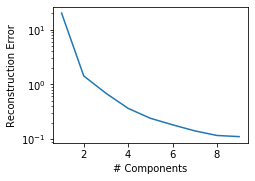

In [10]:
fig, ax = plt.subplots()

ax.semilogy(num_components, recon_error)

ax.set_xlabel('# Components')
ax.set_ylabel('Reconstruction Error')

fig.set_size_inches(3.5, 2.5)

*Finding*: The rate of the error decreasing lowers significantly after 8 components (note that this is a log scale)

In [11]:
n_components = 8

## Enforce Sparsity
We are going to try to make the learned components easier to interpret by enforcing sparsity. That is, we want to decompose patterns into a smaller number of components and have those components be simpler

In [12]:
alphas = np.logspace(-6, 2, 32)

In [13]:
%%time
recon_error = [NMF(n_components=n_components, 
                  alpha=a, l1_ratio=1).fit(raman_spectrum).reconstruction_err_ for a in alphas]

Wall time: 13.3 s


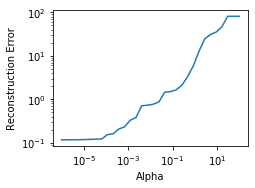

In [14]:
fig, ax = plt.subplots()

ax.loglog(alphas, recon_error)

ax.set_xlabel('Alpha')
ax.set_ylabel('Reconstruction Error')

fig.set_size_inches(3.5, 2.5)

We want the most sparisty that does not seriously mess up the reconstruction. 
That seems to be about $10^{-4}$

### Visualize the Performance
See how good a few patterns look post-reconstruction, if the components make sense, etc

In [15]:
nmf = NMF(n_components=n_components, alpha=1e-4, l1_ratio=1).fit(raman_spectrum)
print(f'NMF error: {nmf.reconstruction_err_:.3e}')

NMF error: 1.526e-01


Transform and then reconstruct all patterns

In [16]:
latent_space = nmf.transform(raman_spectrum)

In [17]:
reconstructed = nmf.inverse_transform(latent_space)

Plot a few

In [18]:
ax.get_legend_handles_labels

<bound method Axes.get_legend_handles_labels of <matplotlib.axes._subplots.AxesSubplot object at 0x0000020F8CD4DE48>>

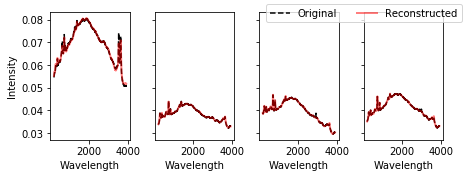

In [19]:
fig, axs = plt.subplots(1, 4, sharey=True)

chosen_ids = np.linspace(0, raman_spectrum.shape[0]-1, 5, dtype=np.int)[:-1]

for pid, ax in zip(chosen_ids, axs):
    ax.plot(two_theta, raman_spectrum[pid], 'k--', label='Original')
    ax.plot(two_theta, reconstructed[pid], 'r-', label='Reconstructed', alpha=0.5, lw=2)

axs[0].set_ylabel('Intensity')
fig.legend(*axs[0].get_legend_handles_labels(), ncol=2)
for ax in axs:
    ax.set_xlabel('Wavelength')
fig.set_size_inches(6.5, 2.5)
fig.tight_layout()

Plot the components

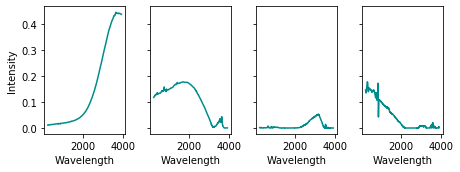

In [20]:
fig, axs = plt.subplots(1, 4, sharey=True)

for pid, ax in enumerate(axs):
    ax.plot(two_theta, nmf.components_[pid, :], color='darkcyan')

axs[0].set_ylabel('Intensity')
for ax in axs:
    ax.set_xlabel('Wavelength')
fig.set_size_inches(6.5, 2.5)
fig.tight_layout()
fig.savefig(os.path.join('figures', 'raman-components.png'), dpi=320)

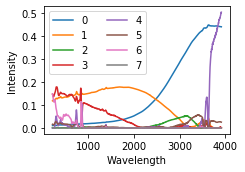

In [21]:
fig, ax = plt.subplots()

for pid in range(nmf.components_.shape[0]):
    ax.plot(two_theta, nmf.components_[pid, :], label=f'{pid}')

ax.set_ylabel('Intensity')
ax.set_xlabel('Wavelength')
ax.legend(ncol=2)
fig.set_size_inches(3.5, 2.5)
fig.tight_layout()
fig.savefig(os.path.join('figures', 'raman-components-alltogether.png'), dpi=320)

**TODO**: Talk to others about these patterns, do they make sense?
They all seem like different peaked functions, which is what my ignorence expected

Plot the change in components

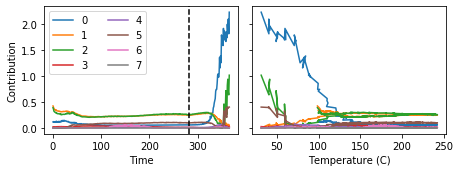

In [22]:
fig, axs = plt.subplots(1, 2, sharey=True)

for i, l in enumerate(latent_space.T):
    axs[0].plot(data['Seq.'], l, label=i)
axs[0].set_xlabel('Time')
axs[0].legend(ncol=2)
axs[1].plot(data['measured temp'], latent_space)
axs[1].set_xlabel('Temperature (C)')

axs[0].set_ylabel('Contribution')
fig.set_size_inches(6.5, 2.5)

axs[0].set_ylim(axs[0].get_ylim())
axs[0].plot([data['Seq.'].loc[data['measured temp'].idxmax()]]*2, axs[0].get_ylim(), 'k--')

fig.tight_layout()
fig.savefig(os.path.join('figures', 'raman-proportions.png'), dpi=320)

**TODO**: The signatures do not seem to vary much in the liquid. Is that expected? Should I cluster only on the liquid?